# Developing a Machine Learning Model for Used Car Price Prediction

Predicting the price of a car(new or used) is a classic case of supervised learning. This notebook focuses on building a learning model to estimate the price of used cars in Germany.

### Dataset:

The dataset was originally scraped from eBay Kleinanzeigen, a classifieds section of the German eBay website. Since the dataset has personal information, it isn't uploaded anywhere. For the current project, only few columns are considered for model development. They are:

| Column name | Description |
|-------------|-------------|
| Price | The selling price on the ad (in Euros) |  
| Vehicle_type | The type of the vehicle |  
| Year_of_registration | The year in which the car was first registered |  
| Gearbox | The transmission type |
| Model | Model name of the car |
| Kms_driven | Number of kilometers driven by the car |
| Fuel_type | Type of fuel the car uses |
| Brand | The brand of the car |
| Unrepaired_damages | Any damage to the car which is not yet repaired |  

### Methodology:

Here are the following steps taken into consideration in developing a prediction model.
1. Data Cleaning - Outlier detection, Handling Missing values
2. Data Visualization 
3. Feature Engineering - Encoding, Scaling and Selection
4. Model Selection - Choosing the best regression model for prediction based on r2 score.
5. Prediction and Evaluation

In [1]:
# Basic Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
# Loading the dataset

data = pd.read_csv('car_data.csv', encoding = "ISO-8859-1")

# Choosing the columns of intereset
car_data = data[['price','vehicleType','yearOfRegistration','gearbox','brand','model','kilometer','fuelType','notRepairedDamage']]

# change the column names
car_data.columns = ['Price', 'Vehicle_type', 'Year_of_registration', 'Gearbox', 'Brand', 'Model',
       'Kms_driven', 'Fuel_type', 'Unrepaired_damages']

car_data.head()

,Price,Vehicle_type,Year_of_registration,Gearbox,Brand,Model,Kms_driven,Fuel_type,Unrepaired_damages
0,480,NaN,1993,manuell,volkswagen,golf,150000,benzin,NaN
1,18300,coupe,2011,manuell,audi,NaN,125000,diesel,ja
2,9800,suv,2004,automatik,jeep,grand,125000,diesel,NaN
3,1500,kleinwagen,2001,manuell,volkswagen,golf,150000,benzin,nein
4,3600,kleinwagen,2008,manuell,skoda,fabia,90000,diesel,nein


### 1. Data Cleaning

This process involves handling the missing values in the dataset by removing any outliers (unusual high/low entries), which might affect in the model prediction.

##### 1.1 Handling Outliers using Inter-Quantile Range (IQR) method

Let's look at the statistical analysis of the numerical columns in the dataset.

In [4]:
car_data.describe()

,Price,Year_of_registration,Kms_driven
count,3.413270e+05,341327.000000,341327.000000
mean,1.791384e+04,2004.613154,125320.279380
std,3.739368e+06,96.871682,40289.529824
min,0.000000e+00,1000.000000,5000.000000
25%,1.050000e+03,1999.000000,100000.000000
50%,2.800000e+03,2003.000000,150000.000000
75%,7.000000e+03,2008.000000,150000.000000
max,2.147484e+09,9999.000000,150000.000000


As seen from the above table, it's clear that there are outliers (surely it's not possible to have an year of 9999, or extremely large price in the order of 10<sup>9</sup>) present in this dataset. To remove such outliers, let's use the Inter-Quantile Range (IQR)<sup>[1]</sup> method. 

In [5]:
def outlier_detect(df):
    """ 
    This function performs the following:
    1. Calculate the first(q1 ~25%) and third quartile(q3 ~75%) 
    2. Calculate IQR = q3 - q1
    3. Find the upper and lower bounds(outer and inner layers)
        a. upper bound = q3 + 1.5 * iqr
        b. lower bound = q1 - 1.5 * iqr
    4. Any data that falls outside the two bounds is an outlier!
    5. Replace such outliers with the nearest bounds
    """
    
    for col in df.describe().columns:
        q1, q3 = np.percentile(df[col], [25,75])
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        
        df[col] = df[col].mask(df[col] < lower_bound, lower_bound) 
        df[col] = df[col].mask(df[col] > upper_bound, upper_bound) 
    return df

In [6]:
# handling outliers
car_data = outlier_detect(car_data)

Let's look at the statistical analysis again to check if the outliers issue is resolved.

In [7]:
car_data.describe()

,Price,Year_of_registration,Kms_driven
count,341327.000000,341327.000000,341327.000000
mean,4793.404146,2003.503706,125869.210464
std,4871.511068,7.001989,38773.376947
min,0.000000,1985.500000,25000.000000
25%,1050.000000,1999.000000,100000.000000
50%,2800.000000,2003.000000,150000.000000
75%,7000.000000,2008.000000,150000.000000
max,15925.000000,2021.500000,150000.000000


##### 1.2 Handling Missing Values

Let's look if the dataset has any missing values. If so, how to deal with it...

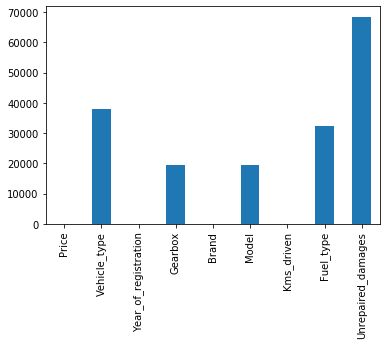

In [8]:
car_data.isnull().sum().plot(kind = 'bar')

It's only the categorical columns which has the missing values, let's follow the Imputation technique to replace them. That is, if it's a categorical column, then replace the missing values with 'the most frequent' value and if it's a numerical column, then replace missing values with the 'mean of that column'.

In [9]:
from sklearn.base import TransformerMixin

class SeriesImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        If the Series is of dtype Object, then impute with the most frequent object.
        If the Series is not of dtype Object, then impute with the mean.  

        """
    def fit(self, X, y = None):
        if X.dtype == np.dtype('O'): 
            self.fill = X.value_counts().index[0]
        else: 
            self.fill = X.mean()
        return self

    def transform(self, X, y = None):
       return X.fillna(self.fill)

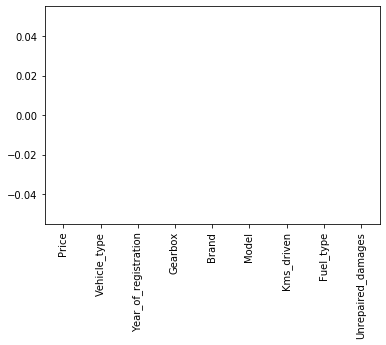

In [10]:
# consider the columns that have missing values
cols = ['Vehicle_type', 'Gearbox' , 'Model', 'Fuel_type', 'Unrepaired_damages']

imputer = SeriesImputer()
for col in cols:
    car_data[col] = imputer.fit_transform(car_data[col])

car_data.isnull().sum().plot(kind = 'bar')  # The plot must have no missing values...

Dataset is now free from missing values. 

##### 1.3 Fixing the dataset
This involves 
- deriving any additional features for visualization or model development
- removing duplicate entries
- fixing the datatypes of numerical columns
- Translating the 'German' words in categorical column to 'English' words

Let's derive another feature from the existing column representing the used-car's age (how old is you car?).

In [11]:
car_data['Current_year'] = 2020
car_data['Age_of_car'] = car_data['Current_year'] - car_data['Year_of_registration']
car_data.drop('Current_year', axis = 1, inplace = True)

# What if there is a car planned to register in 2021?
car_data.drop(car_data[car_data['Age_of_car'] < 0].index, inplace = True)

car_data.head()

,Price,Vehicle_type,Year_of_registration,Gearbox,Brand,Model,Kms_driven,Fuel_type,Unrepaired_damages,Age_of_car
0,480,limousine,1993.0,manuell,volkswagen,golf,150000,benzin,nein,27.0
1,15925,coupe,2011.0,manuell,audi,golf,125000,diesel,ja,9.0
2,9800,suv,2004.0,automatik,jeep,grand,125000,diesel,nein,16.0
3,1500,kleinwagen,2001.0,manuell,volkswagen,golf,150000,benzin,nein,19.0
4,3600,kleinwagen,2008.0,manuell,skoda,fabia,90000,diesel,nein,12.0


Let's look at the datatypes of each columns.

In [12]:
car_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 341213 entries, 0 to 341326
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Price                 341213 non-null  int64  
 1   Vehicle_type          341213 non-null  object 
 2   Year_of_registration  341213 non-null  float64
 3   Gearbox               341213 non-null  object 
 4   Brand                 341213 non-null  object 
 5   Model                 341213 non-null  object 
 6   Kms_driven            341213 non-null  int64  
 7   Fuel_type             341213 non-null  object 
 8   Unrepaired_damages    341213 non-null  object 
 9   Age_of_car            341213 non-null  float64
dtypes: float64(2), int64(2), object(6)
memory usage: 28.6+ MB


In [13]:
# Fixing the datatypes of numerical columns
car_data[['Price','Kms_driven']] = car_data[['Price','Kms_driven']].astype(float)
car_data[['Year_of_registration','Age_of_car']] = car_data[['Year_of_registration','Age_of_car']].astype(int)

In [14]:
# remove duplicate items
if car_data.duplicated().any():
   car_data.drop_duplicates(inplace = True)

car_data.shape

(241146, 10)

In [15]:
# Translate the 'German words' to english!

display(car_data['Vehicle_type'].unique())
display(car_data['Gearbox'].unique())
display(car_data['Fuel_type'].unique())
display(car_data['Unrepaired_damages'].unique())

array(['limousine', 'coupe', 'suv', 'kleinwagen', 'cabrio', 'kombi',
       'andere'], dtype=object)

array(['manuell', 'automatik'], dtype=object)

array(['benzin', 'diesel', 'lpg', 'andere', 'hybrid', 'cng', 'elektro'],
      dtype=object)

array(['nein', 'ja'], dtype=object)

In [16]:
car_data['Vehicle_type'] = car_data['Vehicle_type'].str.replace('kombi','combi').replace('kleinwagen','small car').replace('cabrio','convertible').replace('andere','other')

car_data['Gearbox'] = car_data['Gearbox'].str.replace('manuell','Manual').replace('automatik','Automatic')

car_data['Fuel_type'] = car_data['Fuel_type'].str.replace('benzin','petrol').replace('elektro','electric').replace('andere','other')

car_data['Unrepaired_damages'] = car_data['Unrepaired_damages'].str.replace('nein','No').replace('ja', 'Yes')

In [17]:
car_data.head()

,Price,Vehicle_type,Year_of_registration,Gearbox,Brand,Model,Kms_driven,Fuel_type,Unrepaired_damages,Age_of_car
0,480.0,limousine,1993,Manual,volkswagen,golf,150000.0,petrol,No,27
1,15925.0,coupe,2011,Manual,audi,golf,125000.0,diesel,Yes,9
2,9800.0,suv,2004,Automatic,jeep,grand,125000.0,diesel,No,16
3,1500.0,small car,2001,Manual,volkswagen,golf,150000.0,petrol,No,19
4,3600.0,small car,2008,Manual,skoda,fabia,90000.0,diesel,No,12


##### 1.4 Save Cleaned Dataset

Now that the data is completely cleaned, let's save it for future analysis.

In [18]:
car_data.to_csv('cleaned_car_data.csv', index = False)

### 2. Exploratory Data Analysis

This step involves various plots using Seaborn and Matplotlib to understand the features and their correlation with the target column 'Price'

In [19]:
def categorical_eda(cols,df):
    """This function performs the count plots on various categorical columns in the dataset"""
    for col in cols:
        fig = sns.catplot(x = col, kind = "count", data = df)
        fig.set_xticklabels(rotation = 45)
        plt.show()

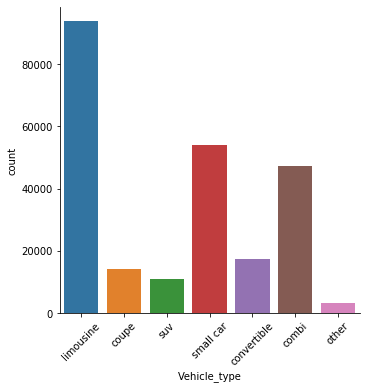

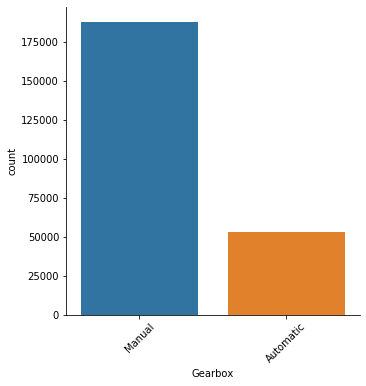

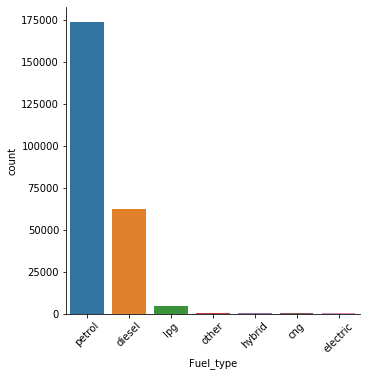

In [20]:
cols = ['Vehicle_type','Gearbox','Fuel_type']
categorical_eda(cols, car_data)

###### Insights:
    - Most of the cars put up for sale are of type 'Limousine', followed by 'Small cars' and 'combi'
    - More than 70% of cars are of petrol and manual-gear types.

Let's identify the most popular car brand in the listing.

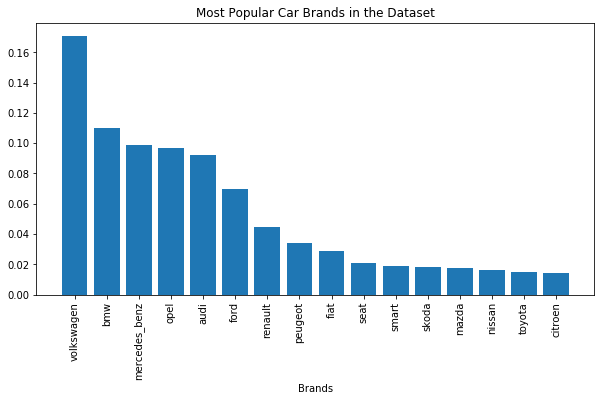

In [21]:
brand_s = car_data['Brand'].value_counts(normalize = True).sort_values(ascending = False)
a = brand_s >= 0.015 # considering only top brand that make 1.5% of listings!
top_brands = list(brand_s[:sum(a) + 1].index)

plt.figure(figsize = (10,5))
plt.bar(top_brands, brand_s[:sum(a) + 1])
plt.xticks(rotation = 90)
plt.title('Most Popular Car Brands in the Dataset')
plt.xlabel('Brands')
plt.show()

###### Insights:
    Around 16% of the cars listed in the dataset is of brand Volkswagen, followed by BMW (11%) and Mercedes Benz (10%)

Let's look at the average price, average age and mileage(Kms_driven) of the popular brands.

In [22]:
car_mean_price = car_data.groupby('Brand')['Price'].mean()
car_mean_mileage = car_data.groupby('Brand')['Kms_driven'].mean()
car_mean_age = car_data.groupby('Brand')['Age_of_car'].mean()

mean_price_top_brands = []
mean_mileage_top_brands = []
mean_age_top_brands = []

for brand in top_brands:
    mean_price_top_brands.append(car_mean_price[brand]) #Price
    mean_mileage_top_brands.append(car_mean_mileage[brand]) #Mileage
    mean_age_top_brands.append(car_mean_age[brand]) #Age
    
top_brand_price = dict(zip(top_brands, mean_price_top_brands))
top_brand_mileage = dict(zip(top_brands, mean_mileage_top_brands))
top_brand_age = dict(zip(top_brands, mean_age_top_brands))

In [23]:
# converting dict to series
top_brand_price_series = pd.Series(top_brand_price)
top_brand_mileage_series = pd.Series(top_brand_mileage)
top_brand_age_series = pd.Series(top_brand_age)

# moving it to dataframe
top_brand_df = pd.DataFrame(top_brand_price_series, columns = ['Avg_Sell_Price'])
top_brand_df['Avg_Kms_driven'] = top_brand_mileage_series
top_brand_df['Avg_age'] = np.ceil(top_brand_age_series)
top_brand_df

,Avg_Sell_Price,Avg_Kms_driven,Avg_age
volkswagen,4689.720430,124323.405908,17.0
bmw,6683.109243,132630.365780,17.0
mercedes_benz,6093.495000,131612.184874,18.0
opel,3032.538827,123607.448630,17.0
audi,6717.803961,131491.736280,17.0
ford,3188.706058,120383.766040,17.0
renault,2427.224607,122758.107983,16.0
peugeot,3166.538949,122510.666829,16.0
fiat,2803.999714,112525.404322,16.0
seat,3962.082060,120319.232276,15.0


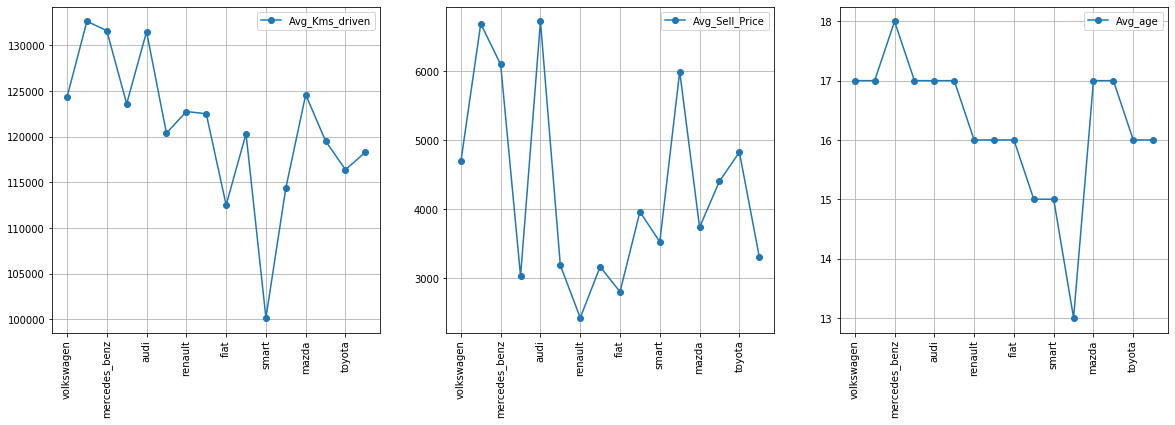

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(1 , 3, figsize = (20, 6))
top_brand_df.plot(y = 'Avg_Kms_driven', grid = True, marker = 'o', ax = ax1)
top_brand_df.plot(y = 'Avg_Sell_Price', grid = True, marker = 'o', ax = ax2)
top_brand_df.plot(y = 'Avg_age', grid = True, marker = 'o', ax = ax3)

for ax in [ax1,ax2,ax3]:
    ax.tick_params(axis = 'x', labelrotation = 90)

###### Insights:
    Considering the dataframe and plots, it's obvious that there is a non-linear relationship between the price and [age, mileage]. Irrespective of the mileage and age, the brands 'Audi', 'BMW' and 'Skoda' are expensive.

###### 2.1 Categorical plots among the most popular brands 

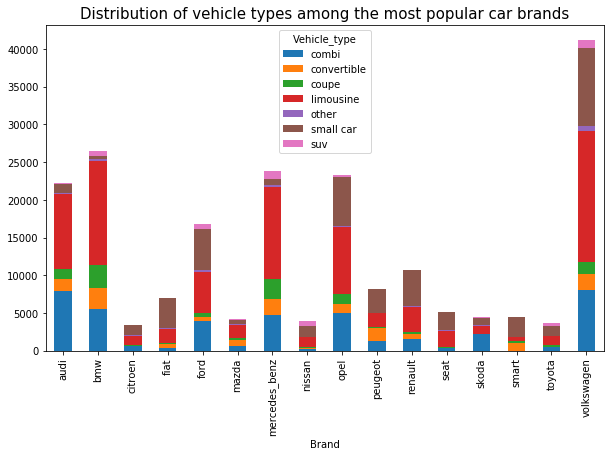

In [25]:
grouping_top = car_data.groupby('Brand')['Vehicle_type'].value_counts()
grouping_top.loc[top_brands].unstack().plot(kind = 'bar', stacked = True, figsize = (10,6))
plt.title('Distribution of vehicle types among the most popular car brands', fontsize = 15)
plt.show()

###### Insights:
    Among the most popular brands, it seems that there is a wide distribution of different vehicle types ranging from convertible, limousine, small car, SUV

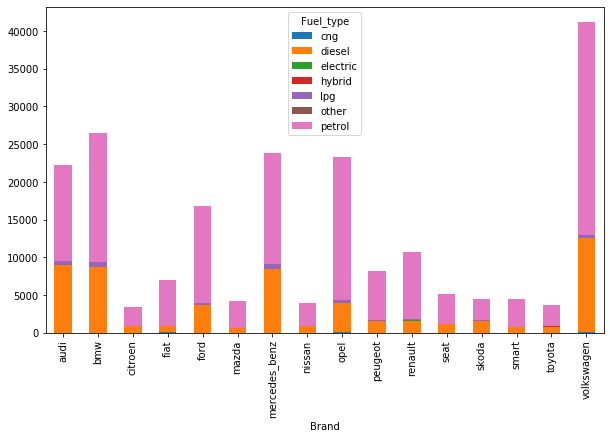

In [26]:
grouping_top = car_data.groupby('Brand')['Fuel_type'].value_counts()
grouping_top.loc[top_brands].unstack().plot(kind = 'bar', stacked = True, figsize = (10,6))
plt.show()

###### Insights:

    There is a predominance of vehicles with Petrol as fuel, among the most popular brands.

###### 2.2 Most Popular Brand-Model Combo

In [27]:
df_brand_model = car_data.groupby(['Brand','Model'])['Year_of_registration'].count().sort_values(ascending = False)

top_brand_model_l = list(df_brand_model.index)
percent_top_brand_model = ((df_brand_model.to_list()) / np.sum(df_brand_model.to_list())) * 100

a = percent_top_brand_model >= 1.5
top_brands_models = top_brand_model_l[:sum(a) + 1]
display(top_brands_models)

[('volkswagen', 'golf'),
 ('bmw', '3er'),
 ('opel', 'astra'),
 ('volkswagen', 'polo'),
 ('audi', 'a4'),
 ('volkswagen', 'passat'),
 ('opel', 'corsa'),
 ('mercedes_benz', 'c_klasse'),
 ('bmw', '5er'),
 ('mercedes_benz', 'e_klasse'),
 ('audi', 'a3'),
 ('audi', 'a6'),
 ('ford', 'fiesta'),
 ('ford', 'focus'),
 ('smart', 'fortwo'),
 ('peugeot', '2_reihe')]

###### 2.3 Feature Target Relationship

Dataset has both categorical and numerical columns. Inorder to determine the weird relationships between each column irrespective of whether they are linear, non-linear or gaussian, Predictive Power Score<sup>[2][3]</sup> is used. The score is 0 if there is no relationship and the score is 1 if there is a perfect relationship.

In [28]:
import ppscore as pps

temp = car_data.copy()
temp.drop('Year_of_registration', axis = 1, inplace = True)

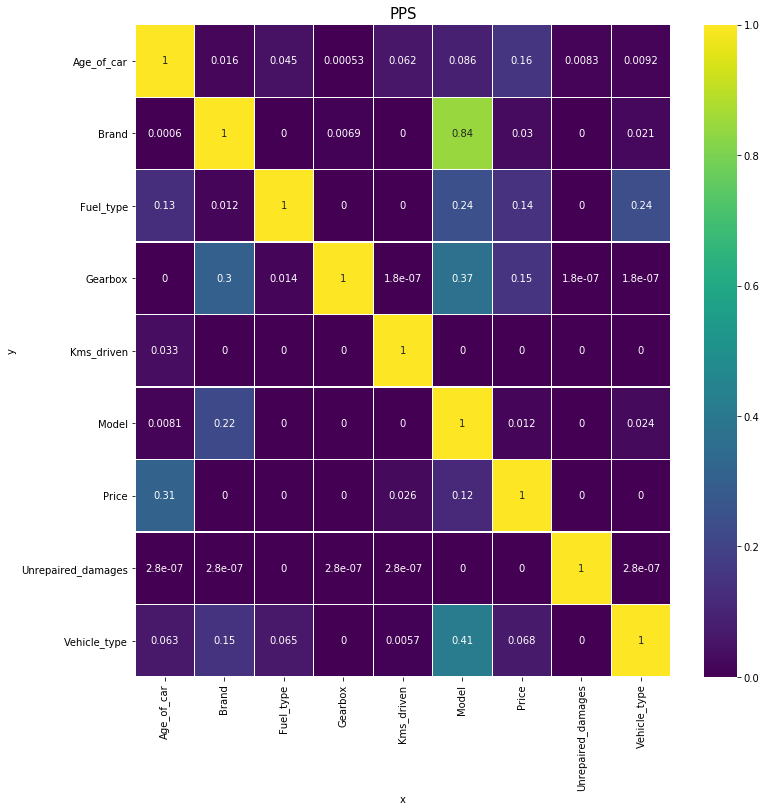

In [29]:
matrix_df = pps.matrix(temp)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
plt.figure(figsize = (12,12))
plt.title('PPS', size = 15)
sns.heatmap(matrix_df, vmax = 1.0, cmap = 'viridis', linewidths = 0.1, annot = True)

###### Insights:
    - Kms_driven only predicts the Price with a PPS score of 0.026 (Weak relationship)
    - Given the Model, its easier to predict Brand because of PPS ~ 0.84
    - There exists a strong relation between (Model, Vehicle type), (Model, Gearbox), (Model, Fuel type) and (Vehicle type, Fuel type)
    - Age_of_car is a predictor of Price with a PPS of 0.31 but the viceversa isnt true.
    - It's also interesting to note that the unrepaired_damages doesnt have any relation with the price! (Weak relation with almost all columns)

### 3. Feature Engineering

This section involves encoding the categorical data, performing feature scaling for developing a learning model.

##### 3.1 Categorical Encoding
Before proceeding further, let's drop the 'Unrepaired_damages' column as its least important for the analysis.  Let's look at the number of labels in each categorical columns

In [30]:
car_data.drop('Unrepaired_damages', axis = 1, inplace = True)

my_col = ['Vehicle_type','Brand','Model','Fuel_type', 'Gearbox']
for col in my_col:
    print(col, ':', len(car_data[col].unique()), 'labels')

Vehicle_type : 7 labels
Brand : 40 labels
Model : 251 labels
Fuel_type : 7 labels
Gearbox : 2 labels


Apart from 'Brand' and 'Model' columns, lets perform one-hot encoding on the categorical columns.

In [31]:
car_data['Gearbox'] = car_data['Gearbox'].str.replace('Manual','1').replace('Automatic', '0').astype(int)

new_col1 = pd.get_dummies(car_data['Fuel_type'], prefix = 'fueltype', drop_first = True)
new_col2 = pd.get_dummies(car_data['Vehicle_type'], prefix = 'vehicletype', drop_first = True)
extra_col = pd.concat([new_col1, new_col2], axis = 1) # now has 12 columns

If 'Brand', 'Model' are both one-hot encoded then number of columns in the dataset will be too large! This can likely cause the data to overfit the learning model. To avoid this, let's try to perform selective(top 5 brand and model) one-hot encoding<sup>[4]</sup>

In [32]:
# let's make a list with the most frequent categories of the [Brand, Model]

def one_hot_encoding_top_x(df, variable, top_x_labels):
    """ function to create the dummy variables for the most frequent labels"""
    
    for label in top_x_labels:
        df[variable+'_'+label] = np.where(df[variable] == label, 1, 0)
        
for col in ['Model', 'Brand']:
    top_5_col = [y for y in car_data[col].value_counts().sort_values(ascending = False).head(5).index]
    one_hot_encoding_top_x(car_data, col, top_5_col)

In [33]:
# concatenate both datasets
final_dataset = pd.concat([car_data, extra_col], axis = 1)

#Let's remove the unnecessary columns
final_dataset.drop(['Vehicle_type','Brand','Model','Fuel_type','Year_of_registration'], axis= 1, inplace = True)

# Display dataset
final_dataset.head()

,Price,Gearbox,Kms_driven,Age_of_car,Model_golf,Model_andere,Model_3er,Model_astra,Model_polo,Brand_volkswagen,...,fueltype_hybrid,fueltype_lpg,fueltype_other,fueltype_petrol,vehicletype_convertible,vehicletype_coupe,vehicletype_limousine,vehicletype_other,vehicletype_small car,vehicletype_suv
0,480.0,1,150000.0,27,1,0,0,0,0,1,...,0,0,0,1,0,0,1,0,0,0
1,15925.0,1,125000.0,9,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,9800.0,0,125000.0,16,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1500.0,1,150000.0,19,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
4,3600.0,1,90000.0,12,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


Let's separate the features from target(Price)

In [34]:
features  = final_dataset.drop('Price', axis = 1)
target = final_dataset['Price'] 

##### 3.2 Feature Importance
Let's find out the features which play an important role in predicting the car price

In [35]:
from sklearn.ensemble import ExtraTreesRegressor

model = ExtraTreesRegressor() 
model.fit(features,target)

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=None, oob_score=False,
                    random_state=None, verbose=0, warm_start=False)

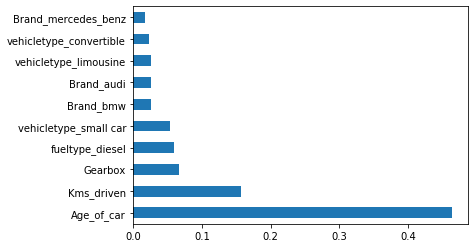

In [36]:
# let's plot the top 10 features that play a role in predicting Car Price 
feat_importances = pd.Series(model.feature_importances_, index = features.columns)

feat_importances.nlargest(10).plot(kind = 'barh')

##### 3.3 Feature Scaling using Standard Scaler

In [37]:
from sklearn.preprocessing import StandardScaler

scale = StandardScaler()
features_scaled = scale.fit_transform(features)

### 4. Model Selection

This section involves choosing the best regression model for predicting the car price based on metric - r2 score.  
But before that, let's analyze the target distribution


 mu = 4801.12 and sigma = 4610.85



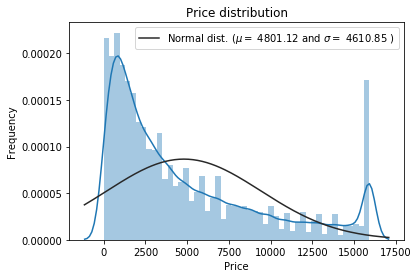

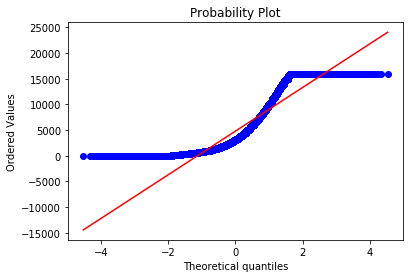

In [38]:
from scipy import stats
from scipy.stats import norm

sns.distplot(target, fit = norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(target)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc = 'best')
plt.ylabel('Frequency')
plt.title('Price distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(target, plot = plt)

###### Insights:

    Target is right skewed. 

Let's split the dataset into training and testing sets

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features_scaled, np.array(target), test_size = 0.3)

##### 4.1 Choosing regression model

Since predicting car price is a case of supervised learning, it is necessary to figure out which regression model will be best for prediction. In this step, different regression models namely Linear, Ridge, Stochastic Gradient Descent (SGD), Random forest Regressor are trained on the training set, evaluated on test sets. Criteria for choosing the best model is based on the metric<sup>[5]</sup> i.e., r2 score. The model with highest r2 score will be chosen as the best model for prediction.

In [40]:
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn import metrics

In [41]:
def r2score (y_true, y_pred):
    """ Function to return the r2 score """
    return metrics.r2_score(y_true, y_pred)

def rmse(y_true, y_pred):
    """ Function to return the root mean square value """
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def model_test(model):
    """
    Generic function that:
        1. Fits the given model on training sets (X_train, y_train)
        2. Predicts the hypothesis on test input (X_test)
        3. Calculates the r2 score/rmse (y_test, hypothesis)
    """
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    model_r2 = round(r2score(y_test, predictions), 4)
    model_rmse = round(rmse(y_test, predictions), 3)
    return model_r2, model_rmse

In [42]:
### Case 1: Linear Regression

lr = LinearRegression()
lr_r2, lr_rsme = model_test(lr)
print("R2 score for Linear Regression is {} and Root Mean Square Error is {}".format(lr_r2, lr_rsme))

R2 score for Linear Regression is 0.4924 and Root Mean Square Error is 3294.17


In [43]:
### Case 2: Ridge Regression

lr_ridge = Ridge(fit_intercept = True, alpha = 0.3)
ridge_r2, ridge_rmse = model_test(lr_ridge)
print("R2 score for Ridge Regression is {} and Root Mean Square Error is {}".format(ridge_r2, ridge_rmse))

R2 score for Ridge Regression is 0.4924 and Root Mean Square Error is 3294.17


In [44]:
### Case 3: Stochastic Gradient Descent

sgdreg = SGDRegressor(penalty = 'l2', alpha = 0.15, max_iter = 200)
sgd_r2, sgd_rmse = model_test(sgdreg)
print("R2 score for Stochastic Gradient Descent is {} and Root Mean Square Error is {}".format(sgd_r2,sgd_rmse))

R2 score for Stochastic Gradient Descent is 0.482 and Root Mean Square Error is 3327.888


In [45]:
### Case 4: Random Forest Regressor

rf = RandomForestRegressor()
rf_r2, rf_rmse = model_test(rf)
print("R2 score for Random Forest Regressor is {} and Root Mean Square Error is {}".format(rf_r2,rf_rmse))

R2 score for Random Forest Regressor is 0.706 and Root Mean Square Error is 2507.091


In [46]:
model_comparison = pd.DataFrame({"Models" : ["Linear regression", "Ridge Regression", "Stochastic Gradient Descent", "Random Forest"],"RMSE" : [lr_rsme, ridge_rmse, sgd_rmse, rf_rmse], "r2_score" : [lr_r2, ridge_r2, sgd_r2, rf_r2]})

Text(0.5, 0, 'r2 score')

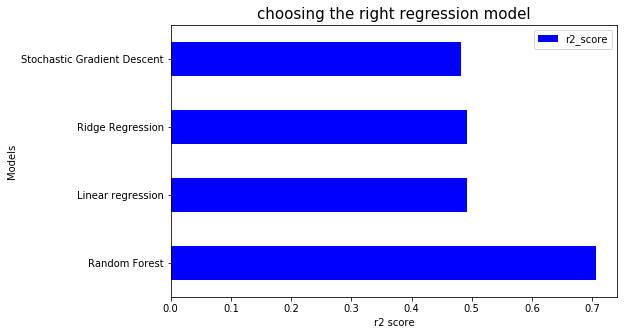

In [47]:
model_comparison.sort_values("r2_score", ascending = False).plot(x = "Models", y = "r2_score", kind = "barh", figsize = (8,5), color = 'blue')
plt.title('choosing the right regression model', fontsize = 15)
plt.xlabel('r2 score')

From the above plot, it is clear that the best model for prediction is Random Forest Regressor. 

### 5. Hyperparameter tuning and Optimization, Prediction and Evaluation

Since the chosen model is 'Random Forest', it's necessary to perform hyperparameter tuning and optimization on cross validation sets.

In [48]:
# Also, there is no need to scale the features for training a Random forest model.

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.3)

In [49]:
from sklearn.model_selection import RandomizedSearchCV

In [50]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 600, num = 6)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [51]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 5, verbose = 2, n_jobs = 1)

In [60]:
rf_random.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=400, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=25 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=400, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=25, total=  56.7s
[CV] n_estimators=400, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=25 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   57.0s remaining:    0.0s


[CV]  n_estimators=400, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=25, total=  52.1s
[CV] n_estimators=400, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=25 
[CV]  n_estimators=400, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=25, total=  50.8s
[CV] n_estimators=400, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=25 
[CV]  n_estimators=400, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=25, total=  51.7s
[CV] n_estimators=400, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=25 
[CV]  n_estimators=400, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=25, total=  50.3s
[CV] n_estimators=500, min_samples_split=15, min_samples_leaf=1, max_features=auto, max_depth=10 
[CV]  n_estimators=500, min_samples_split=15, min_samples_leaf=1, max_features=auto, max_depth=10, total= 2.0min
[CV] n_estimators=500, min_samples_split=15, min_s

[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=5, max_features=sqrt, max_depth=30, total=   9.6s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=5, max_features=sqrt, max_depth=30 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=5, max_features=sqrt, max_depth=30, total=   9.6s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=5, max_features=sqrt, max_depth=30 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=5, max_features=sqrt, max_depth=30, total=   9.7s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=5, max_features=sqrt, max_depth=30 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=5, max_features=sqrt, max_depth=30, total=   9.5s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=5, max_features=sqrt, max_depth=30 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=5, max_features=sqrt, max_depth=30, total=   9.6s
[CV] n_estimators=400, min_samples_split=10

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 39.9min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [66]:
print('Training r2 score:{}'.format(rf_random.score(X_train,y_train)))
print('Test r2 score:{}'.format(rf_random.score(X_test,y_test)))
print('Cross Validation (CV) r2 score:{}'.format(rf_random.best_score_))
print('\nBest parameters for model:')
print(rf_random.best_params_)

Training r2 score:0.7446951406287834
Test r2 score:0.7230956649461823
Cross Validation (CV) r2 score:0.7221740966872092

Best parameters for model:
{'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 30}


r2 score for hyperparameter tuned model is approximately same as default model. Let's check out the time it takes to train both default and tuned model.

In [52]:
default_model = RandomForestRegressor()
hyp_tuned_model = RandomForestRegressor(n_estimators = 100, min_samples_split = 10,min_samples_leaf = 5, max_features = 'sqrt',max_depth = 30)

In [53]:
%%timeit -n 1 -r 5
default_model.fit(X_train, y_train)

52.3 s ± 2.22 s per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [54]:
%%timeit -n 1 -r 5
hyp_tuned_model.fit(X_train,y_train)

14.1 s ± 617 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [55]:
# Predictions
default_pred = default_model.predict(X_test)
hyp_tuned_pred = hyp_tuned_model.predict(X_test)

# Evaluation
print("Default model performance on the test set: r2 score = %0.4f"  %r2score(y_test,default_pred))
print("Tuned model performance on the test set: r2 score = %0.4f" %r2score(y_test,hyp_tuned_pred))

Default model performance on the test set: r2 score = 0.7057
Tuned model performance on the test set: r2 score = 0.7272


Hyperparameter tuned model is much faster to run than the default model. Also there is also a small improvement in r2 score with tuned model. Let's check the error difference between the predicted and actual values.

Text(0.5, 1.0, 'Residual Information')

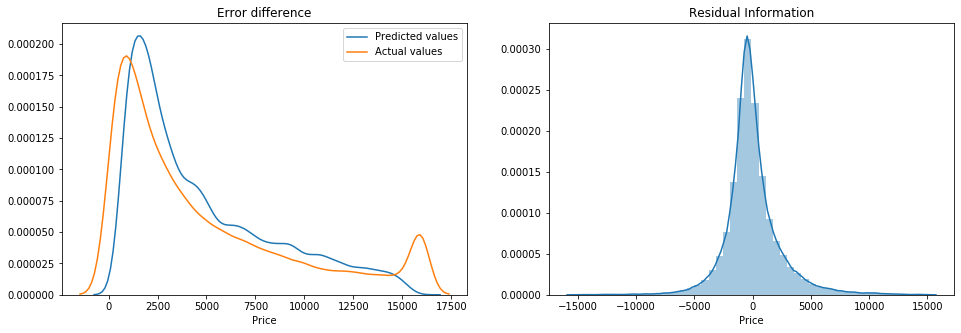

In [56]:
# difference between the predicted and actual values
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16,5))
sns.kdeplot(hyp_tuned_pred, label = "Predicted values", ax = ax1)
sns.kdeplot(y_test, label = "Actual values", ax = ax1)

sns.distplot(y_test - hyp_tuned_pred, ax = ax2)

ax1.set_title('Error difference')
ax1.set_xlabel('Price')
ax2.set_title('Residual Information')

### 6. Conclusion

    Among the different regressor models, hyperparameter-tuned random forest model performed better in predicting the used car's price with an r2 score of 0.72 and lowest RMSE.

### 7. References

[1] [5 Ways to Find Outliers in Your Data](https://statisticsbyjim.com/basics/outliers/)   
[2] [A Python implementation of the Predictive Power Score](https://pypi.org/project/ppscore/)  
[3] [Introducing Predictive Power Score](https://towardsdatascience.com/rip-correlation-introducing-the-predictive-power-score-3d90808b9598)  
[4] [Using Ensemble techniques to One Hot Encoding](http://proceedings.mlr.press/v7/niculescu09/niculescu09.pdf)  
[5] [Metrics to evaluate a regression model](https://towardsdatascience.com/what-are-the-best-metrics-to-evaluate-your-regression-model-418ca481755b)